In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import wfdb
import pandas as pd
import os
import numpy as np
import pickle
from tqdm import tqdm
import random

In [2]:
# Description see https://physionet.org/content/ptb-xl/1.0.0/
df = pd.read_csv("data/ptbxl_database.csv")
df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

ECG statements: core components are scp_codes (SCP-ECG statements as a dictionary with entries of the form statement: likelihood, where likelihood is set to 0 if unknown) and report (report string). Additional fields are heart_axis, infarction_stadium1, infarction_stadium2, validated_by, second_opinion, initial_autogenerated_report and validated_by_human.

In [3]:
# find the scp code related to MI
scp = pd.read_csv("data/scp_statements.csv").rename({'Unnamed: 0':'scp_code'},axis=1)
MI_codes = scp[scp.diagnostic_class=='MI']['scp_code']
MI_codes

5       IMI
6      ASMI
16     ILMI
18      AMI
19     ALMI
21    INJAS
22      LMI
26    INJAL
34    IPLMI
36     IPMI
38    INJIN
39    INJLA
40      PMI
42    INJIL
Name: scp_code, dtype: object

18885 unique patients.
3184.0 patients have MI (likelihood>80%).
7185.0 patients are normal (likelihood=100%).



<AxesSubplot:xlabel='MI', ylabel='Count'>

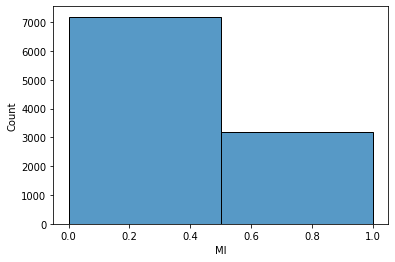

In [6]:
# question: how to treat patients with uncertain MI diagnose?
# here simply: >80 -> MI, NORM -> Not MI.
df['BMI'] = df['weight']/(df['height']/100)/(df['height']/100)
def code_to_MI(code):
    code_dict = ast.literal_eval(code)
    if 'NORM' in code_dict.keys() and code_dict['NORM'] == 100:
        return 0
    for key in code_dict:
        if key in list(MI_codes) and code_dict[key]>=80:
            return 1
df['MI'] = df['scp_codes'].apply(lambda x: code_to_MI(x))
mi_df = df[~df['MI'].isnull()]
print("".join([
    f"{len(df.patient_id.unique())} unique patients.\n",
    f"{sum(mi_df['MI'])} patients have MI (likelihood>80%).\n",
    f"{len(mi_df)- sum(mi_df['MI'])} patients are normal (likelihood=100%).\n",
    ]
))
sns.histplot(df['MI'],bins=2)

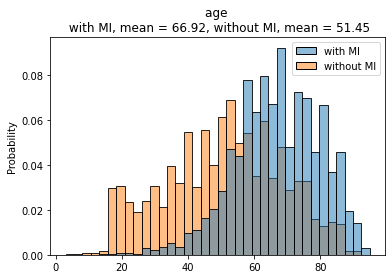

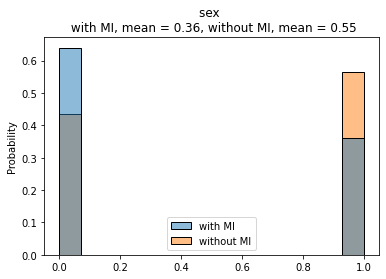

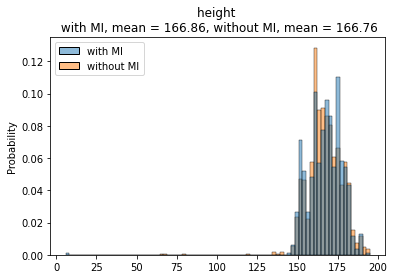

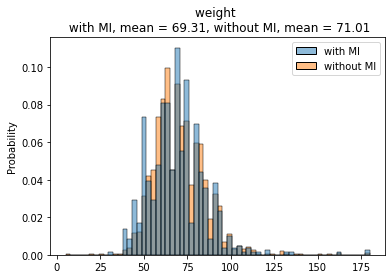

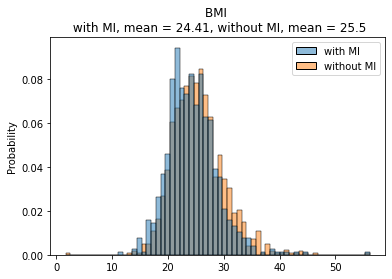

In [7]:
for m in ['age', 'sex', 'height', 'weight','BMI']: # 't_gmax', 'diff_min_premeal''g_min',
    plt.figure()
    compare_df = pd.DataFrame()
    compare_df['with MI'] = df[df['MI']==1][[m]].reset_index()[[m]]
    compare_df['without MI'] = df[df['MI']==0][[m]].reset_index()[[m]]
    sns.histplot(compare_df,stat="probability",common_norm=False)
    plt.title(f"{m} \n with MI, mean = {round(df[df['MI']==1][m].mean(),2)}, without MI, mean = {round(df[df['MI']==0][m].mean(),2)}")

In [8]:
# prepare datasets for experiments
mi_df = df[~df['MI'].isnull()]
total_with_bmi = sum(~mi_df['BMI'].isnull())
mi_df = mi_df.sort_values(by='BMI').reset_index(drop=True)
group_1_indices= list(range(0,int(total_with_bmi/3)))
group_2_indices= list(range(int(total_with_bmi/3),int(total_with_bmi/3*2)))
group_3_indices= list(range(int(total_with_bmi/3*2),total_with_bmi))
mi_df.loc[random.sample(group_1_indices,100),'bmi_group'] = 1 
mi_df.loc[random.sample(group_2_indices,100),'bmi_group'] = 2 
mi_df.loc[random.sample(group_3_indices,100),'bmi_group'] = 3 
mi_df.to_csv("data/mi_df.csv")